In [29]:
import os
import time
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import opensmile


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

import torch
from torch import nn
import torch.nn.functional as F

from tensorflow.keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD




In [3]:
files = glob(r'data/Audio_Speech_Actors_01-24/*/*.wav')

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
dataset = smile.process_files(files)

x = dataset.values
y = np.array([int(os.path.basename(path).split('-')[2]) for path in files])




In [8]:
enc = OneHotEncoder(sparse_output=False)  
y_hot = enc.fit_transform(y.reshape(-1, 1)) 
print(y_hot)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


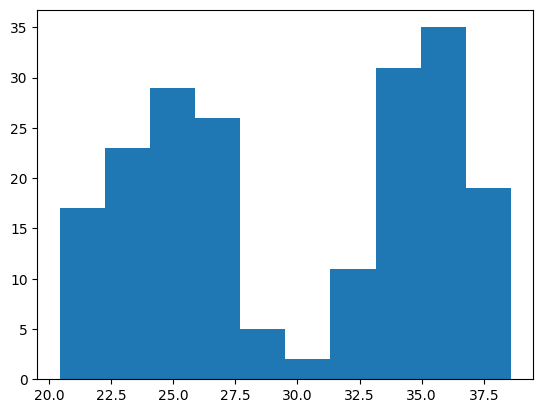

In [45]:
#print(dataset)

plt.hist(dataset['F0semitoneFrom27.5Hz_sma3nz_amean'][y==2])
plt.show()



## Filename identifiers 

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y)
print(x_train.shape)
print(y_train.shape)

(1092, 88)
(1092,)


## Random Forest

In [21]:
random_forest = RandomForestClassifier()
random_forest.fit(x_train, y_train)
y_predict = random_forest.predict(x_test)
print(y_predict[0])
acc = accuracy_score(y_test, y_predict)
print(f"Accuracy {acc}")



2
Accuracy 0.6098901098901099


In [31]:
dim_entrada = x_train.shape[1]
capa_entrada = Input(shape=(dim_entrada,))

encoder = Dense(20, activation='tanh')(capa_entrada)
encoder = Dense(14, activation='relu')(encoder)

decoder = Dense(20, activation='tanh')(encoder)
decoder = Dense(29, activation='relu')(decoder)

autoencoder = Model(inputs=capa_entrada, outputs=decoder)
sgd = SGD(learning_rate=0.01)
autoencoder.compile(optimizer='sgd', loss='mse')

nits = 100
tam_lote = 32
autoencoder.fit(x_train, x_train, epochs=nits, batch_size=tam_lote, shuffle=True, validation_data=(x_test,x_test), verbose=1)

Epoch 1/100


ValueError: in user code:

    File "c:\Users\54911\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\54911\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\54911\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\54911\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1127, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\54911\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "c:\Users\54911\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\54911\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\54911\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\54911\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\losses.py", line 1706, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 29 and 88 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](model_1/dense_7/Relu, IteratorGetNext:1)' with input shapes: [?,29], [?,88].
